<a href="https://colab.research.google.com/github/nuyhc/RhythmStudy/blob/main/1.%20PyTorch/Part_4_RNN_%EB%B0%95%EC%A7%80%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab-11-4 RNN timeseries

## 학습목표

시계열 데이터(Time Series Data)를 순환신경망(Recurrent Neural Network)로 모델링 해본다.

## 핵심키워드

순환신경망(Recurrent Neural Network)  
시계열 데이터(Time Series Data)

## Apply RNN: Data Reading

In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

* linear하게 최소값과 최대값 사이를 선형으로 그어서 linear하게 나눠주는 방식을 취함

In [2]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [5]:
# hyper parameters
seq_length = 7  # 7일
data_dim =  5  # vector의 값이 시가, 최고가, 최저가, 거래량, 종가 -> 5개의 dimension
hidden_dim = 10  # Hidden State dimension
output_dim = 1  # FC layer가 맞춰야하는 종가의 dimension
learning_rate = 0.01  
iterations = 500  # Iteration number

In [ ]:
!wget https://raw.githubusercontent.com/deeplearningzerotoall/PyTorch/master/RNN/data-02-stock_daily.csv

In [23]:
# load data
xy = np.loadtxt("/content/data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 [0.18685758 0.18212236 0.1560484  0.60962624 0.15331987]
 [0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]] -> [0.14877846]
[[0.13075879 0.14979736 0.13950917 0.35107108 0.1339569 ]
 [0.15042457 0.16374824 0.15035617 0.23008873 0.14071632]
 [0.14549092 0.14452321 0.11061926 0.34481491 0.154517  ]
 [0.16681257 0.20764196 0.18773052 0.4378686  0.22527992]
 [0.18685758 0.18212236 0.1560484  0.60962624 0.15331987]
 [0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]
 [0.1172689  0.14037216 0.1430174  0.21129336 0.14877846]] -> [0.12107173]
[[0.15042457 0.16374824 0.15035617 0.23008873 0.14071632]
 [0.14549092 0.14452321 0.11061926 0.34481491 0.154517  ]
 [0.16681257 0.20764196 0.18773052 0.4378686  0.22527992]
 [0.18685758 0.18212236 0.1560484  0.60962624 0.15331987]
 [0.14300667 0.13856872 0.13617972 0.22934481 0.12698631]
 [0.1172689  0.14037216 0.1430174  0.21129336 0.14877846]
 [0.13503702 0.12893923 0.13850679 0.18323922 0.12107173]] -

In [24]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)  # LSTM layer 선언
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)  # FC layer 선언

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)  # Network 출력값이 실수값 -> MSELoss 할당


# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [25]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.2271038144826889
1 0.18340934813022614
2 0.15106436610221863
3 0.1261231154203415
4 0.10598734021186829
5 0.08915016800165176
6 0.07493706792593002
7 0.06327901035547256
8 0.05449602007865906
9 0.04902385175228119
10 0.04693441092967987
11 0.04731706157326698
12 0.04838263615965843
13 0.04839476943016052
14 0.046337660402059555
15 0.04207770526409149
16 0.03620168939232826
17 0.029662001878023148
18 0.023386560380458832
19 0.01801123656332493
20 0.013800659216940403
21 0.010714652948081493
22 0.008532218635082245
23 0.006976508069783449
24 0.005824481602758169
25 0.004987422842532396
26 0.004524712450802326
27 0.004554683342576027
28 0.005089898593723774
29 0.005920968018472195
30 0.006684892810881138
31 0.007072673179209232
32 0.0069739907048642635
33 0.006471904460340738
34 0.005753520876169205
35 0.0050146933645009995
36 0.004395292140543461
37 0.003953743726015091
38 0.003676638239994645
39 0.00351098389364779
40 0.00340130808763206
41 0.003315107664093375
42 0.0032488943543285

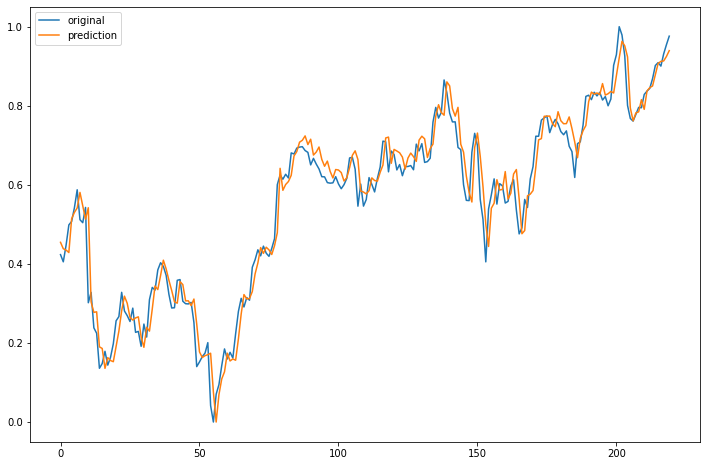

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()